# Foundations of Transformers in Neuroscience Tutorial

Authors: Shivashriganesh Mahato, Vinam Arora | Contributions: Mehdi Azabou, Sergey Shuvaev, Julie Young, Eva Dyer

***

The goal of this notebook is to show you how to work with datasets and dataloaders, build and train several neural decoding models (a simple MLP, a Transformer, and POYO), fine-tune a pretrained POYO model on a new session, and visualize training. This notebook is designed to be interactive and provide visual feedback. As you work through the cells, try to run them and observe the results. Detailed explanations are provided along the way.

<center>
<img src="https://torch-brain.readthedocs.io/en/latest/_static/torch_brain_logo.png" width="150" height="150" alt="torch_brain Logo">
</center>


We will focus on three main topics in this notebook:
* **Part 1: DataLoaders**
* **Part 2: Training Models**
* **Part 3: Finetuning and Visualizations**


General references:

- [**torch_brain** documentation](<https://torch-brain.readthedocs.io/en/latest/index.html>)
- [pytorch tutorials](<https://pytorch.org/tutorials/beginner/basics/intro.html>)

***
## Setup

First, let's install **torch_brain**, and get you set up with some simple utility functions that will be used throughout this notebook.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import warnings
import logging
from torch_brain.utils import seed_everything

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)


def move_to_gpu(data, device):
    """
    Recursively moves tensors (or collections of tensors) to the given device.
    """
    if isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, dict):
        return {k: move_to_gpu(v, device) for k, v in data.items()}
    elif isinstance(data, list):
        return [move_to_gpu(elem, device) for elem in data]
    else:
        return data


def bin_spikes(spikes, num_units, bin_size, right=True, num_bins=None):
    """
    Bins spike timestamps into a 2D array: [num_units x num_bins].
    """
    rate = 1 / bin_size  # avoid precision issues
    binned_spikes = np.zeros((num_units, num_bins))
    bin_index = np.floor((spikes.timestamps) * rate).astype(int)
    np.add.at(binned_spikes, (spikes.unit_index, bin_index), 1)
    return binned_spikes


def r2_score(y_pred, y_true):
    # Compute total sum of squares (variance of the true values)
    y_true_mean = torch.mean(y_true, dim=0, keepdim=True)
    ss_total = torch.sum((y_true - y_true_mean) ** 2)

    # Compute residual sum of squares
    ss_res = torch.sum((y_true - y_pred) ** 2)

    # Compute R^2
    r2 = 1 - ss_res / ss_total

    return r2


def compute_r2(dataloader, model):
    # Compute R2 score over the entire dataset
    total_target = []
    total_pred = []
    for batch in dataloader:
        batch = move_to_gpu(batch, device)
        pred = model(**batch["model_inputs"])
        target = batch["target_values"]

        # Store target and pred for visualization
        mask = torch.ones_like(target, dtype=torch.bool)
        if "output_mask" in batch["model_inputs"]:
            mask = batch["model_inputs"]["output_mask"]
        total_target.append(target[mask])
        total_pred.append(pred[mask])

    # Concatenate all batch outputs
    total_target = torch.cat(total_target)
    total_pred = torch.cat(total_pred)

    # Compute the R2 score
    r2 = r2_score(total_pred.flatten(), total_target.flatten())

    return r2.item(), total_target, total_pred


def print_model(model: torch.nn.Module):
    """
    Prints a summary of the model architecture and parameter count.
    """
    model_str = str(model).split('\n')
    print("\nModel:")
    print('\n'.join(model_str[:5]))
    print("...")
    print('\n'.join(model_str[-min(5, len(model_str)):]))
    num_params = sum(p.numel() for p in model.parameters())
    if num_params > 1e9:
        param_str = f"{num_params/1e9:.1f}G"
    elif num_params > 1e6:
        param_str = f"{num_params/1e6:.1f}M"
    else:
        param_str = f"{num_params/1e3:.1f}K"
    print(f"\nNumber of parameters: {param_str}\n")


def plot_training_curves(r2_log, loss_log):
    """
    Plots the training curves: training loss and validation R2 score.
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(0, len(loss_log), len(loss_log)), loss_log)
    plt.title("Training Loss")
    plt.xlabel("Training Steps")
    plt.ylabel("MSE Loss")
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(r2_log)
    plt.title("Validation R2")
    plt.xlabel("Epochs")
    plt.ylabel("R2 Score")
    plt.grid()
    plt.tight_layout()
    plt.show()


def generate_sinusoidal_position_embs(num_timesteps, dim):
    position = torch.arange(num_timesteps).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2) * (-np.log(10000.0) / dim))
    pe = torch.empty(num_timesteps, dim)
    pe[:, 0:dim // 2] = torch.sin(position * div_term)
    pe[:, dim//2:] = torch.cos(position * div_term)
    return pe


def load_pretrained(ckpt_path, model):
    print("Loading pretrained model...")
    checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    # poyo is pretrained using lightning, so model weights are prefixed with "model."
    state_dict = {k.replace("model.", ""): v for k, v in checkpoint["state_dict"].items()}
    model.load_state_dict(state_dict)
    print("Done!")
    return model


def reinit_vocab(emb_module, vocab):
    emb_module.extend_vocab(vocab)
    emb_module.subset_vocab(vocab)


def get_dataset_config(brainset, sessions):
    brainset_norms = {
        "perich_miller_population_2018": {
            "mean": 0.0,
            "std": 20.0
        }
    }

    config = f"""
    - selection:
      - brainset: {brainset}
        sessions:"""
    if type(sessions) is not list:
        sessions = [sessions]
    for session in sessions:
        config += f"""
          - {session}"""
    config += f"""
      config:
        readout:
          readout_id: cursor_velocity_2d
          normalize_mean: {brainset_norms[brainset]["mean"]}
          normalize_std: {brainset_norms[brainset]["std"]}
          metrics:
            - metric:
                _target_: torchmetrics.R2Score
    """

    config = OmegaConf.create(config)

    return config

***

## Part 1: Data Loading

***

### Table of contents:
* 1.1 The life of a data sample
* 1.2 Setting up a basic data pipeline
* 1.3 Downloading a session

### 1.1 The life of a data sample

In the previous notebook, we saw how **torch_brain.data.Dataset** efficiently produces a data sample. But once a sample is drawn—what happens next?

1.	A data sample originates from the dataset. In **torch_brain**, this typically refers to a short time-slice of a neural recording.
2. Optionally, the sample can be transformed—for example, by applying augmentations such as dropping out neurons or brain regions.
3. Next, the sample is further processed and reshaped into a format suitable for model input. We refer to this step as **tokenization**.
4. The tokenized sample is then **collated** with other samples to form a **batch**.
5.	Finally, the batch is passed through the model for the forward computation and loss evaluation.

This process can be seen visually through the diagram below:

<center>
<img src="https://ik.imagekit.io/7tkfmw7hc/dataloader.png?updatedAt=1743052497906" height=420 />
</center>

That’s a lot of work—and in plain PyTorch, you’d be doing it all by hand. **torch_brain** makes each of these steps easy and intuitive to build and customize.

### 1.2 Setting up a basic data pipeline

Now let's define a utility function to create the training and validation datasets, samplers, and dataloaders.
This function will be used to set up the data for training and validation of our models.

Note: We'll handle tokenization in the next part of this notebook.

In [9]:
from torch_brain.data import Dataset, collate, chain
from torch_brain.data.sampler import RandomFixedWindowSampler, SequentialFixedWindowSampler
from torch.utils.data import DataLoader

def get_train_val_loaders(recording_id=None, cfg=None, batch_size=32, seed=0):
    """Sets up train and validation Datasets, Samplers, and DataLoaders
    """

    # -- Train --
    train_dataset = Dataset(
        root="cybershuttle/nerdslab-neurodata25",  # root directory where .h5 files are found
        recording_id=recording_id,  # you either specify a single recording ID
        config=cfg,                 # or a config for multi-session training / more complex configs
        split="train",
    )
    # We use a random sampler to improve generalization during training
    train_sampling_intervals = train_dataset.get_sampling_intervals()
    train_sampler = RandomFixedWindowSampler(
        sampling_intervals=train_sampling_intervals,
        window_length=1.0,          # context window of samples
        generator=torch.Generator().manual_seed(seed),
    )
    # Finally combine them in a dataloader
    train_loader = DataLoader(
        dataset=train_dataset,      # dataset
        sampler=train_sampler,      # sampler
        batch_size=batch_size,      # num of samples per batch
        collate_fn=collate,         # the collator
        num_workers=4,              # data sample processing (slicing, transforms, tokenization) happens in parallel; this sets the amount of that parallelization
        pin_memory=True,
    )

    # -- Validation --
    val_dataset = Dataset(
        root="cybershuttle/nerdslab-neurodata25",
        recording_id=recording_id,
        config=cfg,
        split="valid",
    )
    # For validation we don't randomize samples for reproducibility
    val_sampling_intervals = val_dataset.get_sampling_intervals()
    val_sampler = SequentialFixedWindowSampler(
        sampling_intervals=val_sampling_intervals,
        window_length=1.0,
    )
    # Combine them in a dataloader
    val_loader = DataLoader(
        dataset=val_dataset,
        sampler=val_sampler,
        batch_size=batch_size,
        collate_fn=collate,
        num_workers=4,
        pin_memory=True,
    )

    train_dataset.disable_data_leakage_check()
    val_dataset.disable_data_leakage_check()

    return train_dataset, train_loader, val_dataset, val_loader

***

## Part 2: Training Models

***

In this section, we walk through training different neural decoders. We'll structure the code so there's a common training loop, then move onto implementing:

- A simple MLP Neural Decoder
- A Transformer-based Neural Decoder [2]
- POYO! [3]

### 2.1 Warmup: Implementing an MLP based Neural Activity Decoder

To learn how to write and train models in the `torch_brain` framework, let's kick things off with a simple MLP Neural Decoder.

#### 2.1.1 Defining the Model

In **torch_brain**, every model needs to define two important methods:
1. `model.tokenize`: the tokenization step, which processes and reshapes data to align with model input.
2. `model.forward`: the forward pass, which produces predictions.

In case of an MLP decoder, these will look like:

<center>
<img src="https://ik.imagekit.io/7tkfmw7hc/mlp.png?updatedAt=1743064332486" width=900 />
</center>

In [7]:
import torch.nn as nn

class MLPNeuralDecoder(nn.Module):
    def __init__(self, num_units, bin_size, sequence_length, output_dim, hidden_dim):
        """Initialize the neural net layers."""
        super().__init__()

        self.num_timesteps = int(sequence_length / bin_size)
        self.bin_size = bin_size

        self.net = nn.Sequential(
            nn.Linear(self.num_timesteps * num_units, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * self.num_timesteps),
        )

    def forward(self, x):
        """Produces predictions from a binned spiketrain.
        This is pure PyTorch code.

        Shape of x: (B, T, N)
        """

        x = x.flatten(1)                          # (B, T, N)    -> (B, T*N)
        x = self.net(x)                           # (B, T*N)     -> (B, T*D_out)
        x = x.reshape(-1, self.num_timesteps, 2)  # (B, T*D_out) -> (B, T, D_out)
        return x

    def tokenize(self, data):
        """tokenizes a data sample, which is a sliced Data object"""

        # A. Extract and bin neural activity (data.spikes)
        spikes = data.spikes
        x = bin_spikes(
            spikes=spikes,
            num_units=len(data.units),
            bin_size=self.bin_size,
            num_bins=self.num_timesteps
        ).T
        # Final shape of x here is (timestamps, num_neurons)

        # B. Extract the corresponding cursor velocity, which will act as targets
        #    for training the MLP.
        y = data.cursor.vel
        # Final shape of y is (timestamps x 2)
        # Note that in this example we have choosen the bin size to match the
        # sampling rate of the recorded cursor velocity.

        # Finally, we output the "tokenized" data in the form of a dictionary.
        data_dict = {
            "model_inputs": {
                "x": torch.tensor(x, dtype=torch.float32),
                # Models in torch_brain typically follow the convention that
                # fields that are input to model.forward() are stored in
                # "model_inputs". Although you are free to deviate from this,
                # we have found that this convention generally produces cleaner
                # training loops.
            },
            "target_values": torch.tensor(y, dtype=torch.float32),
        }
        return data_dict

**More on tokenization:**

Recall that a data sample emitted by the Dataset is only sliced in time, but still
contains all fields present in the dataset. In the tokenizer, we:
1. Extract the fields relevant to our machine learning problem. In this case, we only care about the spiketrain and the cursor velocity.
2. Process and reshape the extracted data in a format that is convenient for our model to process. In our example, we bin the spiketrain.

#### 2.1.2 Defining the Training Loop

The following functions perform the training steps. At each epoch, we use the data loader to sample batches of data and train the model using an optimizer. We then compute the R² score on the validation set to monitor the model's performance. This `train` function trains the model for a specified number of epochs and logs the R² score on the validation set.

In [10]:
import torch.nn.functional as F

def train(model, optimizer, train_loader, val_loader, num_epochs=50, store_embs=False):
    # We'll store some intermediate outputs for visualization
    train_outputs = {
        'n_epochs': num_epochs,
        'unit_emb': [],
        'session_emb': [],
        'output_pred': [],
        'output_gt': [],
    }

    r2_log = []
    loss_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Compute R² score on validation set
        r2, target, pred = compute_r2(val_loader, model)
        r2_log.append(r2)

        # Training steps
        for batch in train_loader:
            batch = move_to_gpu(batch, device)
            loss = training_step(batch, model, optimizer)
            loss_log.append(loss.item())

        print(f"\rEpoch {epoch+1}/{num_epochs} | Val R2 = {r2:.3f} | Loss = {loss.item():.3f}", end="")

        # Store intermediate outputs
        if store_embs:
            train_outputs['unit_emb'].append(model.unit_emb.weight[1:].detach().cpu().numpy())
            train_outputs['session_emb'].append(model.session_emb.weight[1:].detach().cpu().numpy())
        train_outputs['output_gt'].append(target.detach().cpu().numpy())
        train_outputs['output_pred'].append(pred.detach().cpu().numpy())

    # Compute final R² score
    r2, _, _ = compute_r2(val_loader, model)
    r2_log.append(r2)
    print(f"\nDone! Final validation R2 = {r2:.3f}")

    return r2_log, loss_log, train_outputs


def training_step(batch, model, optimizer):
    optimizer.zero_grad()                  # Step 0. Clear old gradients
    pred = model(**batch["model_inputs"])  # Step 1. Do forward pass
    target = batch["target_values"]
    loss = F.mse_loss(pred, target)        # Step 2. Compute loss
    loss.backward()                        # Step 3. Backward pass
    optimizer.step()                       # Step 4. Update model params
    return loss


Num Units in Session: 55
Epoch 100/100 | Val R2 = 0.558 | Loss = 5.405
Done! Final validation R2 = 0.561


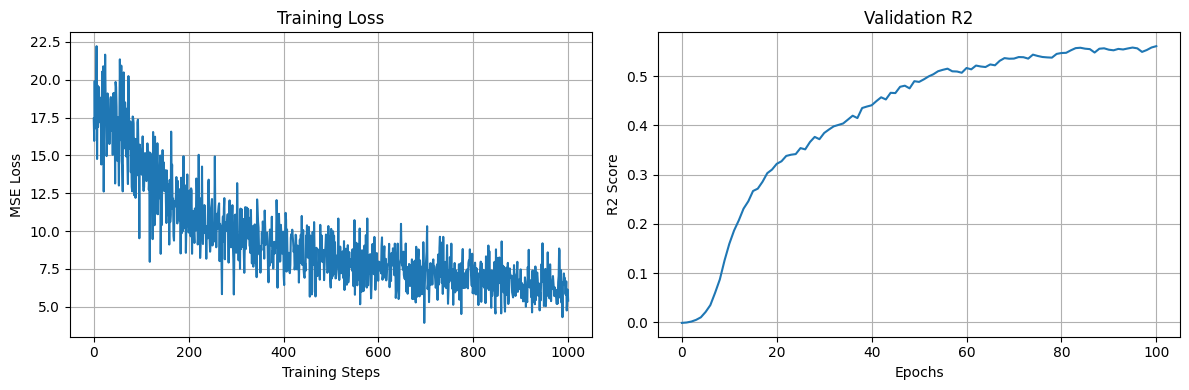

In [13]:
seed_everything(0)

# 1. Setup datasets and dataloader
recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(recording_id, batch_size=64)
num_units = len(train_dataset.get_unit_ids())
print(f"Num Units in Session: {num_units}")

# 2. Initialize Model with the new MLP definition
mlp_model = MLPNeuralDecoder(
    num_units=num_units,    # Num. of units inputted (spiking activity)
    #
    bin_size=10e-3,         # Duration (s) of bins
    sequence_length=1.0,    # Context length of the model
    #
    output_dim=2,           # Output dimension of final readout layer
    hidden_dim=32,          # Hidden dimension of the model
)
mlp_model = mlp_model.to(device)

# 3. Connect Tokenizer to Datasets
transform = mlp_model.tokenize
train_dataset.transform = transform
val_dataset.transform = transform

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=1e-3)

# 5. Train!
mlp_r2_log, mlp_loss_log, mlp_train_outputs = train(mlp_model, optimizer, train_loader, val_loader, num_epochs=100)

# Plot the training loss and validation R2
plot_training_curves(mlp_r2_log, mlp_loss_log)


You should now see a training loss curve steadily decreasing and the validation R² rising. These trends mean your model is learning effectively!

### 2.2 Training a simple Transformer for Neural Decoding
Next up: let's move on to the main course - Transformers! Let's explore how attention can be used for neural decoding by building and training a simple transformer.

#### 2.2.1 Defining a Transformer model

The philosophy of having a `model.tokenize` and `model.forward` methods remains the same as before, however our model is a bit more complex than the humble MLP.

<center>
  <img src="https://ik.imagekit.io/7tkfmw7hc/transformer.png?updatedAt=1743064332335" alt="The Transformer model architecture." width=900/>
</center>


In [14]:
from torch_brain.nn import FeedForward

class TransformerNeuralDecoder(nn.Module):
    def __init__(
        self, num_units, bin_size, sequence_length,   # data properties
        dim_output, dim_hidden, n_layers, n_heads,    # transformer properties
    ):
        """Initialize the neural net components"""
        super().__init__()

        self.num_timesteps = int(sequence_length / bin_size)
        self.bin_size = bin_size

        # Create the read-in/out linear layers
        self.readin = nn.Linear(num_units, dim_hidden)
        self.readout = nn.Linear(dim_hidden, dim_output)

        # Create the position embeddings
        # Note that these are kept constant in this implementation, i.e. _not_ learnable
        self.position_embeddings = nn.Parameter(
            data=generate_sinusoidal_position_embs(self.num_timesteps, dim_hidden),
            requires_grad=False,
        )

        # Create the transformer layers:
        # each composed of the Attention and the feedforward (FFN) blocks
        self.transformer_layers = nn.ModuleList([
            nn.ModuleList([
                nn.MultiheadAttention(
                    embed_dim=dim_hidden,
                    num_heads=n_heads,
                    batch_first=True,
                ),
                FeedForward(dim=dim_hidden),
            ])
            for _ in range(n_layers)
        ])

    def forward(self, x):
        """Produces predictions from a binned spiketrain.
        This is pure PyTorch code.

        Shape of x: (B, T, N)
        """

        # Read-in: converts our input marix to transformer tokens; one token for each timestep
        x = self.readin(x)  # (B, T, N) -> (B, T, D)

        # Add position embeddings to the tokens
        x = x + self.position_embeddings[None, ...]  # -> (B, T, D)

        # Transformer
        for attn, ffn in self.transformer_layers:
            x = x + attn(x, x, x, need_weights=False)[0]
            x = x + ffn(x)

        # Readout: converts tokens to 2d vectors; each vector signifying (v_x, v_y) at that timestep
        x = self.readout(x)  # (B, T, D) -> (B, T, 2)

        return x

    def tokenize(self, data):
        # Same tokenizer as the MLP

        # A. Bin spikes
        x = bin_spikes(
            spikes=data.spikes,
            num_units=len(data.units),
            bin_size=self.bin_size,
            num_bins=self.num_timesteps,
        ).T

        # B. Extract targets
        y = data.cursor.vel

        data_dict = {
            "model_inputs": {
                "x": torch.tensor(x, dtype=torch.float32),
            },
            "target_values": torch.tensor(y, dtype=torch.float32),
        }
        return data_dict

#### 2.2.2 Let's train!

Epoch 100/100 | Val R2 = 0.696 | Loss = 3.768
Done! Final validation R2 = 0.701


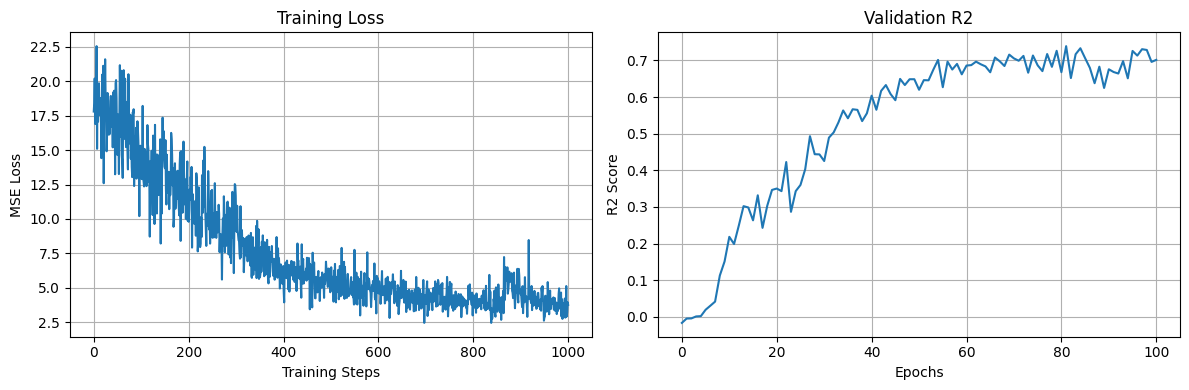

In [15]:
seed_everything(0)

# 1. Setup datasets and dataloader
recording_id = "perich_miller_population_2018/t_20130819_center_out_reaching"
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(recording_id, batch_size=64)
num_units = len(train_dataset.get_unit_ids())

# 2. Initialize Model
tf_model = TransformerNeuralDecoder(
    num_units=num_units,    # Num. of units inputted (spiking activity)
    #
    bin_size=10e-3,         # Duration (s) of bins
    sequence_length=1.0,    # Context length of the model
    #
    dim_output=2,           # Output dimension of final readout layer
    dim_hidden=128,         # Hidden dimension of the model
    n_layers=3,             # Num. of transformer layers
    n_heads=4,              # Num. of heads in MHA blocks
).to(device)

# 3. Connect Tokenizer to Datasets
train_dataset.transform = tf_model.tokenize
val_dataset.transform = tf_model.tokenize

# 4. Setup Optimizer
optimizer = torch.optim.AdamW(tf_model.parameters(), lr=1e-3)

# 5. Train!
transformer_r2_log, transformer_loss_log, transformer_train_outputs = train(tf_model, optimizer, train_loader, val_loader, num_epochs=100)

# Plot the training loss and validation R2
plot_training_curves(transformer_r2_log, transformer_loss_log)